<a href="https://colab.research.google.com/github/nitaymayo/My_Portfolio/blob/main/AI/Tensorflow/Project_Number_1_Food_Vision_Big.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Vesion Big

A model that is trained on food101 data set and gets to a 80% accuracy on a validation dataset

## Starting Up

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
tf.__version__

'2.11.0'

In [ ]:
!nvidia-smi

Fri Jan 13 22:07:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Helper Functions

In [ ]:
! wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-01-13 22:07:32--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-01-13 22:07:32 (117 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import *

## Data Preperation

In [ ]:
import tensorflow_datasets as tfds

In [ ]:
(train_data_raw, test_data_raw), ds_info = tfds.load(name='food101',
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True)

In [ ]:
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [ ]:
one_sample = train_data_raw.take(5)

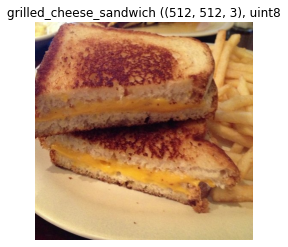

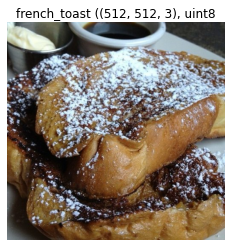

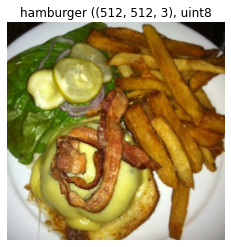

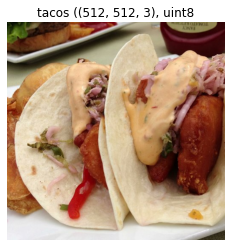

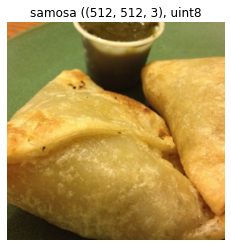

In [ ]:
for img, label in one_sample:
  plt.figure()
  plt.imshow(img)
  plt.title(f"{class_names[label]} ({img.shape}, {img.dtype.name}")
  plt.axis(False)
  # print(f"""
  # img shape: {img.shape}
  # img dtype: {img.dtype}
  # label: {label}
  # class: {class_names[label]}
  # """)

In [ ]:
def preprocess_function(image, label, img_shape=224):
  img = tf.image.resize(image, [img_shape, img_shape])

  return tf.cast(img, 'float32'), label

preprocessed_img, _ = preprocess_function(img, label)

print(f"""
img before: {img[:2]}
shape: {img.shape} and type: {img.dtype.name}

after: {preprocessed_img[:2]}
shape: {preprocessed_img.shape} and type: {preprocessed_img.dtype.name}

""")


img before: [[[214 128  51]
  [212 126  49]
  [209 123  46]
  ...
  [154 152 101]
  [155 154 100]
  [155 154 100]]

 [[215 129  52]
  [213 127  50]
  [212 126  49]
  ...
  [152 150  99]
  [154 153  99]
  [155 154 100]]]
shape: (512, 512, 3) and type: uint8

after: [[[213.35713  127.35715   50.357143]
  [210.33163  124.331635  47.33163 ]
  [211.28061  125.28061   48.709187]
  ...
  [150.06636  149.8521   100.28062 ]
  [152.11736  150.11736   99.117355]
  [154.58676  153.58676   99.586754]]

 [[215.31123  129.31123   54.311222]
  [217.85715  131.85715   56.85714 ]
  [213.85715  127.85715   52.857143]
  ...
  [148.42853  148.21426   98.64279 ]
  [150.00511  148.00511   97.00512 ]
  [152.09694  151.09694   97.09694 ]]]
shape: (224, 224, 3) and type: float32




## Prepare Batch Data

In [ ]:
# def squeeze(img, label):
#   img = tf.squeeze(img)
#   return img, label

In [ ]:
# for img, label in train_data.take(1):
#   squeeze(img, label)
#   print(img.shape)

In [ ]:
train_data = train_data_raw.map(map_func=preprocess_function, num_parallel_calls=tf.data.AUTOTUNE)

train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

test_data = test_data_raw.map(map_func=preprocess_function, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_data, test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

## Creating Model Callbacks

In [ ]:
checkpoint_path = 'model_checkpoint/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy",
                                                      verbose=0,
                                                      save_best_only=True,
                                                      save_weights_only=True)

In [ ]:
! nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-30310521-3aef-911d-c8d1-13dfb43a7a67)


## Setup Mixed Percision

In [ ]:
from tensorflow.keras import mixed_precision

mixed_precision.set_global_policy('mixed_float16')

## Build The Model

In [ ]:
from tensorflow.keras import layers


input_shape = (224, 224, 3)

base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape)

x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation('softmax', dtype='float32')(x)

model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer="Adam",
                metrics=["accuracy"])



## Fit the feature extraction stage

In [ ]:
feature_extraction_history = model_1.fit(train_data,
                                         epochs=3,
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[model_checkpoint,
                                                    create_tensorboard_callback("101_food_vision_model",
                                                                                "feature_extraction_3_epochs")])

Saving TensorBoard log files to: 101_food_vision_model/feature_extraction_3_epochs/20230113-220922
Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7156 - accuracy: 0.5831

2368/2368 [==============================] - 202s 79ms/step - loss: 1.7156 - accuracy: 0.5831 - val_loss: 1.1327 - val_accuracy: 0.6954
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.1994 - accuracy: 0.6898

2368/2368 [==============================] - 182s 76ms/step - loss: 1.1994 - accuracy: 0.6899 - val_loss: 1.0303 - val_accuracy: 0.7235
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0547 - accuracy: 0.7231

2368/2368 [==============================] - 186s 78ms/step - loss: 1.0547 - accuracy: 0.7231 - val_loss: 0.9929 - val_accuracy: 0.7235


In [ ]:
model_1.save_weights(checkpoint_path)

In [ ]:
model_1.save_weights("/content/drive/MyDrive/tensorflow course/Food Vision Project/feature_extraction_model/model.ckpt")

## Evaluation

In [ ]:
result_feature_extraction_model = model_1.evaluate(test_data)
result_feature_extraction_model

790/790 [==============================] - 53s 67ms/step - loss: 0.9987 - accuracy: 0.7272


[0.9986713528633118, 0.7272475361824036]

## Fine Tunning

In [ ]:
for layer in model_1.layers:
  layer.trainable = True

In [ ]:
for i, layer in enumerate(model_1.layers):
  print(i, layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

0 input_4 True float32 <Policy "float32">
1 efficientnetb0 True float32 <Policy "mixed_float16">
2 global_average_pooling2d_1 True float32 <Policy "mixed_float16">
3 dense True float32 <Policy "mixed_float16">
4 activation True float32 <Policy "float32">


## Callbacks


In [ ]:
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
checkpoint_callback_fine_tune = tf.keras.callbacks.ModelCheckpoint('fine_tune_checkpoints/model.ckpt', save_weights_only=True)

In [ ]:
tensorboard_callback = create_tensorboard_callback('101_food_vision_model',
                                                   'fine_tune_model')

Saving TensorBoard log files to: 101_food_vision_model/fine_tune_model/20230113-225627


## Compile the model

In [ ]:
model_1.compile(loss='sparse_categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                metrics=["accuracy"])

In [ ]:
initial_epoch = feature_extraction_history.epoch[-1]
initial_epoch

2

In [ ]:
fine_tune_epochs = 100

fine_tune_history = model_1.fit(train_data,
                                epochs=fine_tune_epochs,
                                initial_epoch=initial_epoch,
                                validation_data=test_data,
                                validation_steps=int(0.15 * len(test_data)),
                                callbacks=[earlystopping_callback,
                                           checkpoint_callback_fine_tune,
                                           tensorboard_callback])

Epoch 3/100
2368/2368 [==============================] - 393s 165ms/step - loss: 0.5393 - accuracy: 0.8506 - val_loss: 0.7602 - val_accuracy: 0.7958
Epoch 4/100
2368/2368 [==============================] - 384s 161ms/step - loss: 0.3023 - accuracy: 0.9132 - val_loss: 0.8515 - val_accuracy: 0.7807
Epoch 5/100
2368/2368 [==============================] - 389s 163ms/step - loss: 0.1575 - accuracy: 0.9526 - val_loss: 0.9121 - val_accuracy: 0.7924
Epoch 6/100
2368/2368 [==============================] - 392s 164ms/step - loss: 0.1003 - accuracy: 0.9693 - val_loss: 0.9820 - val_accuracy: 0.7937


In [ ]:
model_1.save_weights('fine_tune_checkpoints/model.ckpt')